In [19]:
!pip install scikit-learn
!pip install seaborn
!pip install statsmodels
!pip install matplotlib

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
df = pd.read_csv("merged_levels.csv")

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32504 entries, 0 to 32503
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date                       32504 non-null  object
 1   state                      32504 non-null  object
 2   cases_new                  32504 non-null  int64 
 3   cases_import               32504 non-null  int64 
 4   cases_recovered            32504 non-null  int64 
 5   cases_active               32504 non-null  int64 
 6   cases_cluster              32504 non-null  int64 
 7   cases_unvax                32504 non-null  int64 
 8   cases_pvax                 32504 non-null  int64 
 9   cases_fvax                 32504 non-null  int64 
 10  cases_boost                32504 non-null  int64 
 11  daily_partial_child        32504 non-null  int64 
 12  daily_full_child           32504 non-null  int64 
 13  daily_booster_child        32504 non-null  int64 
 14  daily_

In [23]:
#taking all the overall data
df = df.loc[df["state"]=='Overall']

In [24]:
df.head()
df.tail()

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,...,discharged_covid,icu_covid,vent_covid,beds_covid,beds_icu_covid,total_child_vax,total_adol_vax,total_adult_vax,total_elderly_vax,MCO
32424,2025-04-15,Overall,102,0,80,77072,0,25,0,17,...,2,0,0,1616,156,0,0,0,0,0
32441,2025-04-16,Overall,104,0,94,77197,0,23,1,22,...,5,0,0,1677,158,0,0,0,0,0
32458,2025-04-17,Overall,101,0,84,77316,0,28,0,26,...,2,0,1,1596,157,0,0,0,0,0
32475,2025-04-18,Overall,95,0,102,77290,0,33,0,23,...,2,0,0,1543,155,0,0,0,0,0
32492,2025-04-19,Overall,47,1,64,77152,0,11,0,11,...,1,0,0,1271,137,0,0,0,0,0


In [25]:
df['date'] = pd.to_datetime(df['date'])

#create lag features
df['cases_lag_1'] = df['cases_new'].shift(1)
df['cases_lag_7'] = df['cases_new'].shift(7)
df['cases_lag_7'] = df['cases_new'].shift(14)

#rolling averages
df['cases_ma_7'] = df['cases_new'].rolling(window=7).mean()

In [26]:
feature_cols = [col for col in df.columns if col not in ['date', 'cases_new','state']]
X = df[feature_cols]
y = df['cases_new']

In [27]:
#correlation with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print("\nTop 10 Features by Correlation:")
print(correlations.head(10))

# Random Forest Importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 Features by Random Forest Importance:")
print(rf_importance.head(10))


Top 10 Features by Correlation:
cases_lag_1         0.992118
cases_ma_7          0.988347
cases_active        0.973734
cases_recovered     0.927012
cases_lag_7         0.903143
admitted_covid      0.875753
discharged_covid    0.856165
cases_fvax          0.849141
cases_unvax         0.769594
beds_covid          0.767694
dtype: float64

Top 10 Features by Random Forest Importance:
cases_lag_1            0.919510
cases_ma_7             0.061115
daily_partial_child    0.003268
cases_unvax            0.002514
cases_fvax             0.002379
cases_boost            0.001805
cases_pvax             0.001738
admitted_covid         0.001161
cases_import           0.000592
cases_active           0.000540
dtype: float64


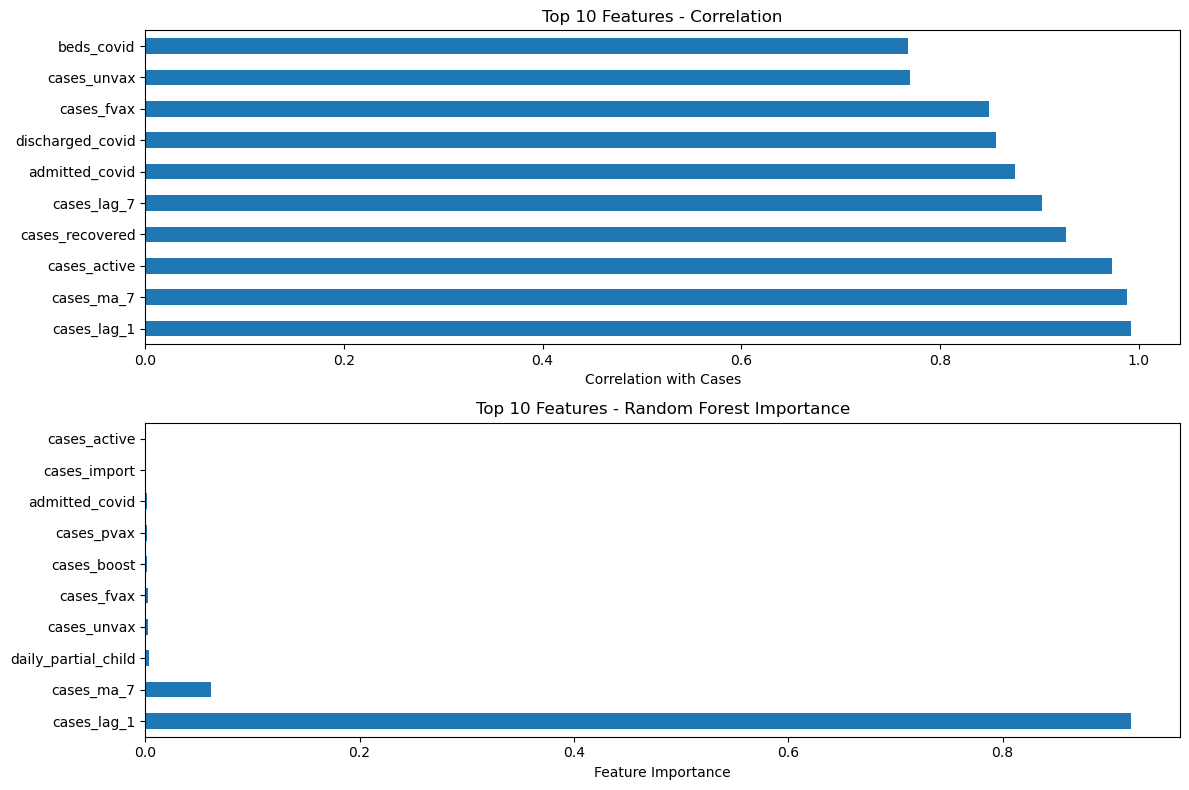

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
correlations.head(10).plot(kind='barh', title='Top 10 Features - Correlation')
plt.xlabel('Correlation with Cases')

plt.subplot(2, 1, 2)
rf_importance.head(10).plot(kind='barh', title='Top 10 Features - Random Forest Importance')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [29]:
#TimeSeriesSplit object with 3 splits
total_records = len(df)
train_size = int(0.8 * total_records)
df_sorted = df.sort_values('date').reset_index(drop=True)

train_df = df_sorted.iloc[:train_size].copy()
test_df = df_sorted.iloc[train_size:].copy()

In [30]:
#Training ARIMA model
train_cases = train_df.set_index('date')['cases_new']
arima_model = ARIMA(train_cases,order=(2,1,2))
arima_fitted = arima_model.fit()


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [66]:
X_train = train_df[feature_cols]
y_train = train_df['cases_new']
X_test = test_df[feature_cols]
y_test = test_df['cases_new']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=200, max_depth = 10, random_state = 42)
rf_model.fit(X_train_scaled, y_train)


#Suren-> just adding code for trained random model forest

import joblib

# Save the trained Random Forest model
joblib.dump(rf_model, "random_forest_model.pkl")
print("Model saved as random_forest_model.pkl")


Model saved as random_forest_model.pkl


In [32]:
#Predictions on test data
print(f"Forecasting {len(test_df)} steps with ARIMA...")
arima_pred = arima_fitted.forecast(steps=len(test_df))
print(f"ARIMA prediction shape: {arima_pred.shape}")

rf_pred = rf_model.predict(X_test_scaled)
print(f"Random Forest prediction shape: {rf_pred.shape}")
print(f"Test data shape: {y_test.shape}")

Forecasting 383 steps with ARIMA...
ARIMA prediction shape: (383,)
Random Forest prediction shape: (383,)
Test data shape: (383,)


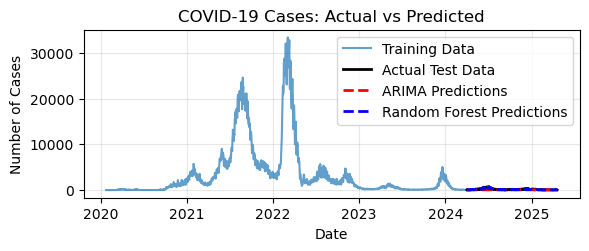

In [33]:
#Time series with predictions
plt.subplot(2, 1, 1)
plt.plot(train_df['date'], train_df['cases_new'], label='Training Data', alpha=0.7)
plt.plot(test_df['date'], y_test, label='Actual Test Data', color='black', linewidth=2)
plt.plot(test_df['date'], arima_pred, label='ARIMA Predictions', color='red', linestyle='--', linewidth=2)
plt.plot(test_df['date'], rf_pred, label='Random Forest Predictions', color='blue', linestyle='--', linewidth=2)
plt.title('COVID-19 Cases: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True, alpha=0.3)


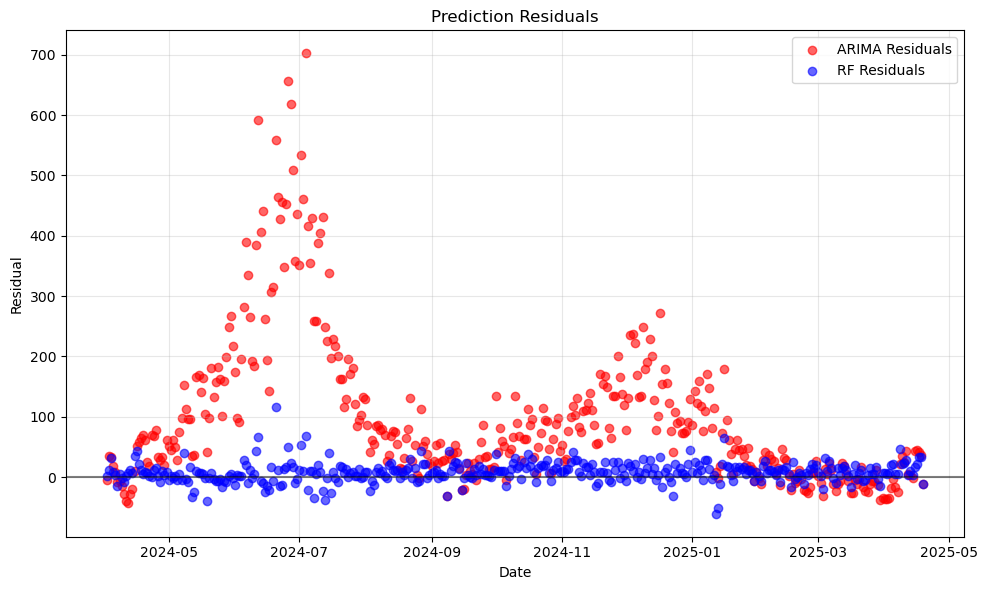

In [34]:
#residual plot
arima_residuals = pd.Series(
    y_test.values - arima_pred,
    index=test_df['date']
)
rf_residuals    = pd.Series(
    y_test.values - rf_pred,
    index=test_df['date']
)

# 3. Plot
plt.figure(figsize=(10,6))
plt.scatter(arima_residuals.index, arima_residuals,
            label='ARIMA Residuals', color='red',   alpha=0.6)
plt.scatter(rf_residuals.index,    rf_residuals,
            label='RF Residuals',    color='blue',  alpha=0.6)
plt.axhline(0, color='black', linestyle='-', alpha=0.5)
plt.title('Prediction Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Future predictions for next 30 days:
ARIMA model predicts average of 59 cases per day


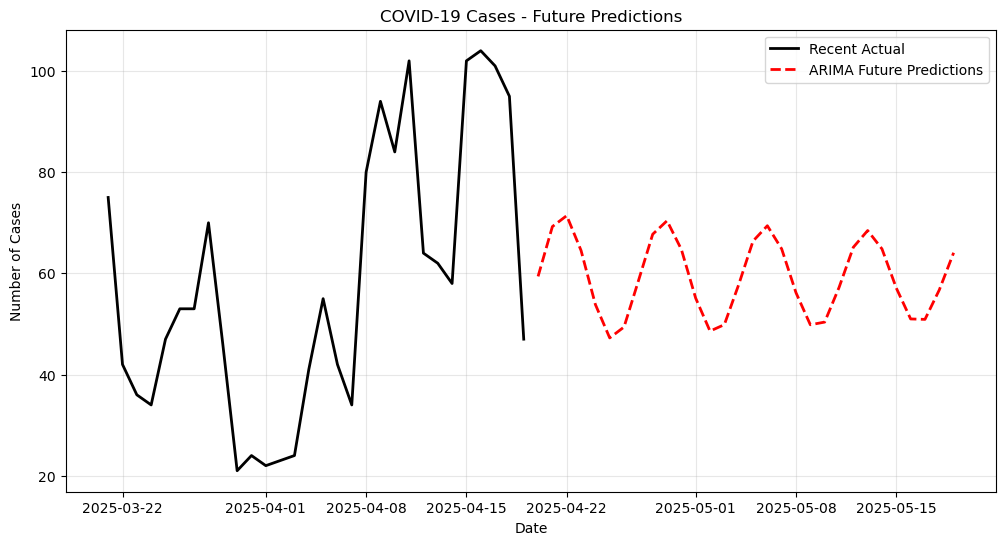

In [35]:
future_dates = pd.date_range(start=test_df['date'].max() + pd.Timedelta(days=1), periods=30, freq='D')

# ARIMA future predictions
arima_future = arima_fitted.forecast(steps=30)

print(f"\nFuture predictions for next 30 days:")
print(f"ARIMA model predicts average of {arima_future.mean():.0f} cases per day")

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(test_df['date'].tail(30), y_test.tail(30), label='Recent Actual', color='black', linewidth=2)
plt.plot(future_dates, arima_future, label='ARIMA Future Predictions', color='red', linestyle='--', linewidth=2)
plt.title('COVID-19 Cases - Future Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

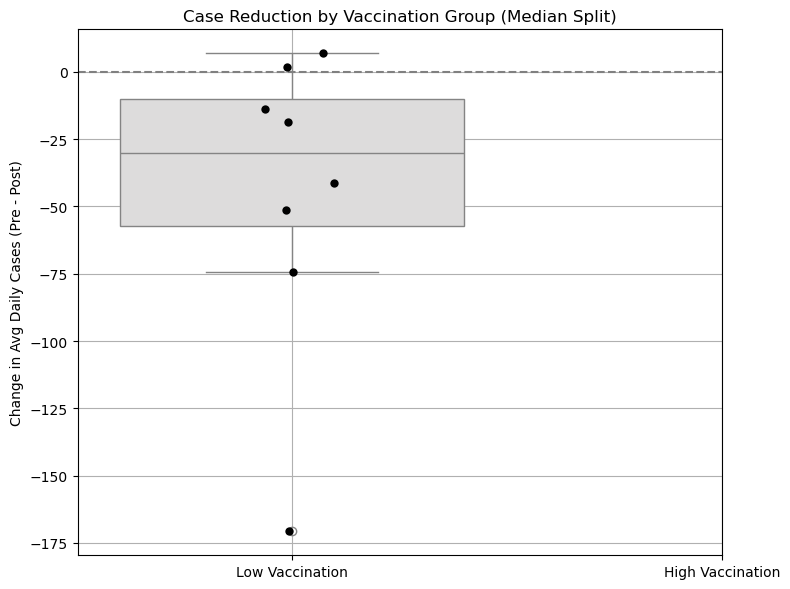

{'T-test p-value': 0.0588, 'Mann-Whitney U-test p-value': 0.0148, 'Mean case change (High vax)': -45.28, 'Mean case change (Low vax)': -92.5, 'Vaccination threshold (median)': 0.0211}


In [62]:
# === Evaluation: Vaccine Impact on Case Reduction ===

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date formatting
df['date'] = pd.to_datetime(df['date'])

# ❌ No 'date' column in demographic data — skip this
# demo_df['date'] = pd.to_datetime(demo_df['date'], errors='coerce')

# Filter out 'Overall'
state_df = df[df['state'] != 'Overall'].copy()

# Cutoff date for vaccine impact comparison
cutoff_date = pd.to_datetime("2021-08-01")

# Calculate average daily cases pre- and post-cutoff per state
pre_cases = state_df[state_df['date'] < cutoff_date].groupby('state')['cases_new'].mean()
post_cases = state_df[state_df['date'] >= cutoff_date].groupby('state')['cases_new'].mean()
case_change = pre_cases - post_cases  # Positive = case reduction

# Cumulative vaccination before cutoff
state_df['cumulative_full'] = state_df.groupby("state")['daily_full_adult'].cumsum()
final_vax = state_df[state_df['date'] < cutoff_date].groupby("state")['cumulative_full'].max()

# Prepare demographic data
demo_grouped = demo_df.groupby("state").agg({
    'population': 'sum',
    'income_mean': 'mean',
    'income_median': 'mean'
})

# Merge all into summary dataframe
summary_df = pd.DataFrame({
    "case_change": case_change,
    "total_vax": final_vax
}).join(demo_grouped)

summary_df["vax_rate"] = summary_df["total_vax"] / (summary_df["population"] * 1000)

# Use median split for group comparison
median_threshold = summary_df["vax_rate"].median()
summary_df["vax_group"] = np.where(summary_df["vax_rate"] >= median_threshold, "High", "Low")

high = summary_df[summary_df["vax_group"] == "High"]["case_change"]
low = summary_df[summary_df["vax_group"] == "Low"]["case_change"]

# Perform statistical tests
t_stat, t_p = ttest_ind(high, low, equal_var=False)
u_stat, u_p = mannwhitneyu(high, low)

# Boxplot for visual comparison
plt.figure(figsize=(8, 6))
sns.boxplot(data=[low, high], palette="coolwarm")
sns.stripplot(data=[low, high], color='black', jitter=True, size=6)
plt.xticks([0, 1], ['Low Vaccination', 'High Vaccination'])
plt.ylabel("Change in Avg Daily Cases (Pre - Post)")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Case Reduction by Vaccination Group (Median Split)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Output results
print({
    "T-test p-value": round(t_p, 4),
    "Mann-Whitney U-test p-value": round(u_p, 4),
    "Mean case change (High vax)": round(high.mean(), 2),
    "Mean case change (Low vax)": round(low.mean(), 2),
    "Vaccination threshold (median)": round(median_threshold, 4)
})
